In [8]:
import sys
import os

project_root = os.path.abspath("..")  
sys.path.append(project_root)

import numpy as np
import random
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

from src.env.TestEnv import HydroElectric_Test
from src.models.PPO import PPOWrapper

In [9]:
seed = 5
np.random.seed(seed)
random.seed(seed)

train_path = os.path.abspath("../data/train.xlsx")
env = HydroElectric_Test(train_path)
env = PPOWrapper(env, reward_shape=True)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    seed=seed
)

model.learn(total_timesteps=300_000,log_interval=10000)
model.save("ppo_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [13]:
val_path = os.path.abspath("../data/validate.xlsx")
env_test = HydroElectric_Test(val_path)
env_test = PPOWrapper(env_test, reward_shape=False)

model = PPO.load("ppo_model")
obs, _ = env_test.reset()

done = False
water_levels = []
rewards = []
actions = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, _ = env_test.step(action)
    done = terminated or truncated
    
    water_levels.append(env_test.env.volume) 
    rewards.append(reward)
    actions.append(action[0])

print("Total reward:", round(sum(rewards),2))
print("Mean reward:", round(np.mean(rewards),3))


Total reward: 8175.09
Mean reward: 0.467


In [14]:
print(len(set(water_levels)))
print(len(set(actions)))
print(len(set(rewards)))

17519
17484
17519


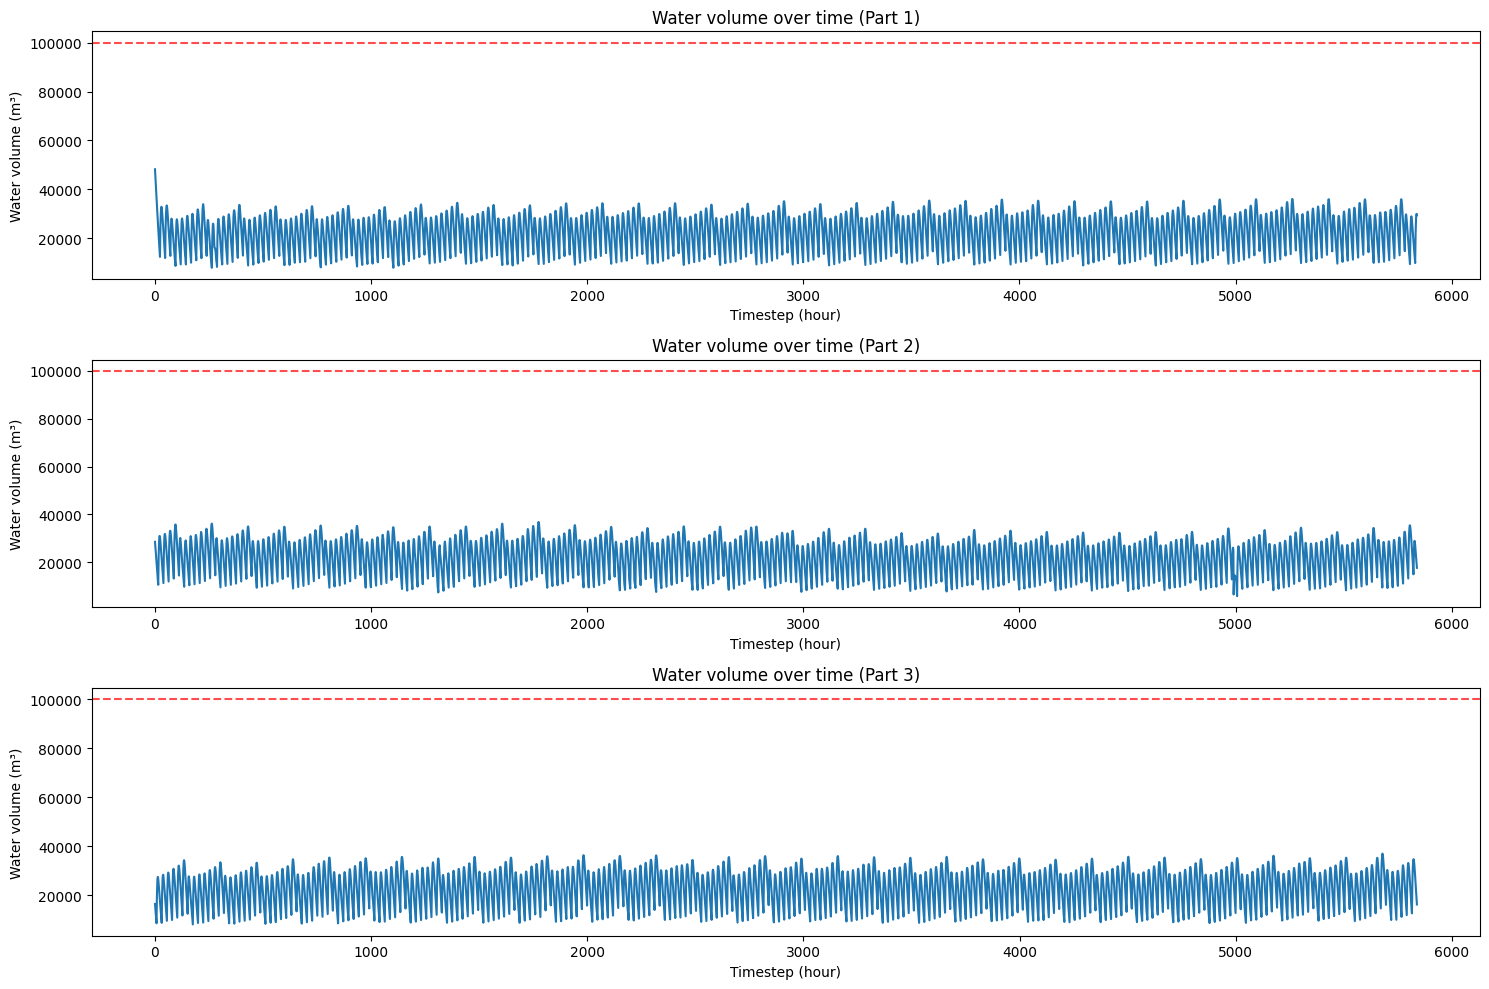

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Stel: water_levels bevat alle uren over 3 jaar
# en env.max_volume is de maximale waterhoeveelheid

# Aantal plots
n_plots = 3

# Verdeel de data in n_plots stukken
chunks = np.array_split(water_levels, n_plots)

plt.figure(figsize=(15,10))

for i, chunk in enumerate(chunks, 1):
    plt.subplot(n_plots, 1, i)
    plt.plot(chunk)
    plt.axhline(env.max_volume, color='r', linestyle='--', alpha=0.7)
    plt.title(f"Water volume over time (Part {i})")
    plt.xlabel("Timestep (hour)")
    plt.ylabel("Water volume (m³)")

plt.tight_layout()
plt.show()


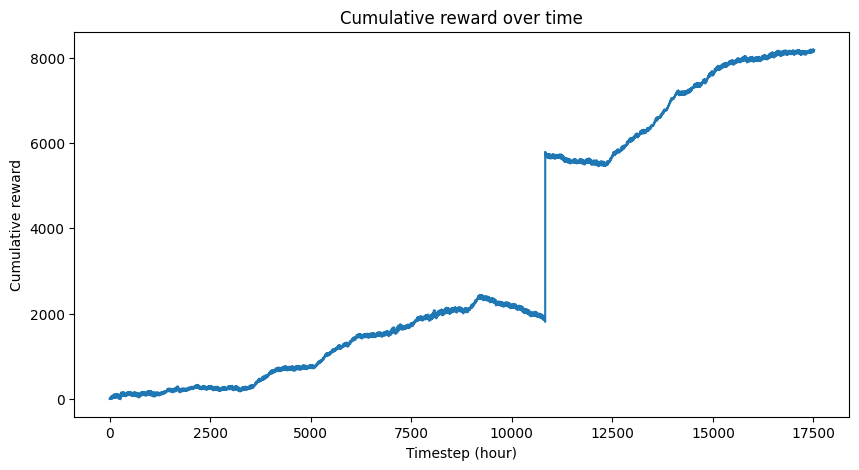

In [16]:
# Plot cumulatieve reward
%matplotlib inline
cumulative_rewards = np.cumsum(rewards)
plt.figure(figsize=(10,5))
plt.plot(cumulative_rewards)
plt.title("Cumulative reward over time")
plt.xlabel("Timestep (hour)")
plt.ylabel("Cumulative reward")
plt.show()